In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas numpy scipy matplotlib seaborn fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.1 MB/s eta 0:00:00


# Dicionário de Variáveis (Dataset WEC)

As colunas presentes na base de dados bruta e processada são descritas a seguir:

-   `X1` a `X16`: Coordenadas cartesianas no eixo horizontal ($X$) para cada um dos 16 conversores de energia das ondas no arranjo.
-   `Y1` a `Y16`: Coordenadas cartesianas no eixo vertical ($Y$) para cada um dos 16 conversores de energia das ondas no arranjo.
-   `P1` a `P16`: Potência individual gerada por cada conversor (geralmente removidas após a consolidação para focar na performance do grupo).
-   **`Powerall`**: Variável alvo (target) que representa a potência total líquida gerada pelo arranjo de 16 WECs, considerando as interações hidrodinâmicas.
-   **`scenario`**: Identificador da localização geográfica e condições metereológicas do dataset (ex.: *Adelaide*, *Tasmania*, *Sydney* e *Perth*).

O dataset abrange quatro localizações reais na costa australiana, cada uma com características distintas de espectro de onda:

1.  **Adelaide:** Águas mais rasas e regime de ondas regular.
2.  **Tasmania:** Alta energia e condições climáticas severas.
3.  **Sydney:** Regime de ondas moderado.
4.  **Perth:** Influência de ventos consistentes e swells de longo período.

Área de Ocupação: Todas as coordenadas ($X, Y$) estão contidas dentro de uma área delimitada de 566m x 566m, definindo o espaço operacional da fazenda de ondas.

------------------------------------------------------------------------

# Introdução e Objetivo

Este projeto foca no processamento e engenharia de atributos de um dataset de **Conversores de Energia das Ondas (WECs - Wave Energy Converters)**. O objetivo principal é transformar coordenadas espaciais ($X, Y$) em um formato otimizado para modelos de *Regressão linear*, extraindo métricas geométricas que descrevam a disposição física dos conversores no oceano.

A meta é criar um pipeline de dados para que o algoritmo de regressão consiga prever a eficiência do arranjo para cada cenário geográfico.

## Detalhamento do Contexto e Desafios

### O Efeito de Interação Hidrodinâmica

O principal desafio na modelagem de fazendas de ondas (*WEC Farms*) é o **Efeito Wake (Esteira)**. Assim como em parques eólicos, quando um conversor extrai energia de uma onda, ele cria uma "sombra" ou zona de menor energia atrás de si, alterando o recurso disponível para os conversores vizinhos.

A potência total ($Powerall$) é uma soma linear das potências individuais em isolamento, porém o posicionamento dos **WECs** impacta diretamente a quantidade de energia gerada por **WECs** adjacentes.

$$Powerall = \sum_{i=1}^{16} P_i$$

### Por que a Engenharia de Atributos é Vital para Regressão Linear?

Modelos de Regressão Linear assumem que a variável dependente é uma combinação linear das variáveis independentes. No entanto, as coordenadas puras ($X, Y$) raramente têm uma relação linear direta com a potência. Ao extrair métricas como **distância ao centroide** e **distância mínima**, estamos:

-   **Capturando Não-Linearidades:** A distância euclidiana (que envolve termos quadráticos e raízes) "pré-processa" a geometria para o modelo, permitindo que a regressão linear encontre coeficientes significativos para a dispersão espacial.
-   **Tratando a Invariância Espacial:** O modelo passa a entender a relação *entre* os WECs, em vez de apenas suas posições absolutas no mapa.

------------------------------------------------------------------------

# Pipeline de Processamento e Engenharia de Atributos

## Leitura e Consolidação dos Dados

-   Leitura dos arquivos CSV brutos para cada cenário (*Adelaide*, *Tasmania*, *Sydney*, *Perth*).
-   Atribuição de nomes de colunas e adição de uma coluna `scenario` para identificar a origem dos dados.
-   Salvamento em formato `.parquet` para otimização de leitura e escrita.

In [ ]:
from pathlib import Path
import pandas as pd

# Diretórios (usar Path para poder usar / corretamente)
RAW_DIR = Path("/content/drive/MyDrive/DL/P1_RL/data/raw")
PROCESSED_DIR = Path("/content/drive/MyDrive/DL/P1_RL/data/processed")

# Cria a pasta processed se não existir
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Arquivos por cenário
files = {
    "Adelaide": "Adelaide_Data.csv",
    "Tasmania": "Tasmania_Data.csv",
    "Sydney": "Sydney_Data.csv",
    "Perth": "Perth_Data.csv"
}

# Colunas
x_cols = [f"X{i}" for i in range(1, 17)]
y_cols = [f"Y{i}" for i in range(1, 17)]
p_cols = [f"P{i}" for i in range(1, 17)]

columns = x_cols + y_cols + p_cols + ["Powerall"]

dfs = []

for scenario, filename in files.items():
    file_path = RAW_DIR / filename

    # Leitura do CSV
    df = pd.read_csv(file_path, header=None)
    df.columns = columns

    # Adiciona coluna de cenário
    df["scenario"] = scenario

    # Salva parquet
    output_path = PROCESSED_DIR / f"{scenario.lower()}.parquet"
    df.to_parquet(output_path, index=False, engine="fastparquet")

    print(f"{scenario} salvo em {output_path}")

    dfs.append(df)

# Concatena todos os cenários
wec_all = pd.concat(dfs, ignore_index=True)

# Salva dataset final
output_path = PROCESSED_DIR / "wec_all.parquet"
wec_all.to_parquet(output_path, index=False, engine="fastparquet")

print(f"\nDataset final salvo em: {output_path}")
print(f"Shape final: {wec_all.shape}")

Adelaide salvo em /content/drive/MyDrive/DL/P1_RL/data/processed/adelaide.parquet
Tasmania salvo em /content/drive/MyDrive/DL/P1_RL/data/processed/tasmania.parquet
Sydney salvo em /content/drive/MyDrive/DL/P1_RL/data/processed/sydney.parquet
Perth salvo em /content/drive/MyDrive/DL/P1_RL/data/processed/perth.parquet

Dataset final salvo em: /content/drive/MyDrive/DL/P1_RL/data/processed/wec_all.parquet
Shape final: (287999, 50)


## Remoção de Colunas de Potência Individual

1.  A decisão de remover as colunas `P1` a `P16` foi tomada para evitar que o modelo de regressão linear se torne dependente das potências individuais, que não estarão disponíveis em um cenário de previsão real. O foco é extrair informações geométricas dos WECs, como suas posições relativas, para prever a potência total `Powerall`.

2.  Evitar a multicolinearidade: As potências individuais estão altamente correlacionadas com a potência total, o que pode levar a problemas de *Dataleakage*, já que:

$$Powerall = \sum_{i=1}^{16} P_i$$

In [ ]:
import pandas as pd

df = pd.read_parquet(PROCESSED_DIR / "wec_all.parquet")

p_cols = [f"P{i}" for i in range(1, 17)]
df.drop(columns=p_cols, inplace=True)
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,Y9,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Powerall,scenario
0,316.5855,223.9277,182.3434,551.5497,7.8641,243.1339,361.0877,115.9284,78.6087,468.3799,...,495.7867,105.5203,141.8014,18.7857,496.6488,3.2835,513.9628,105.5529,1370374.145,Adelaide
1,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,415.6457,410.1439,156.3712,532.9900,280.7516,559.2803,208.7441,531.3943,1340929.765,Adelaide
2,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,435.2397,35.5588,148.9206,48.0585,317.9832,26.8732,483.0186,359.0875,1352031.511,Adelaide
3,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,562.7245,347.2173,0.0000,272.3906,178.4930,317.5044,235.5983,19.6762,1396754.375,Adelaide
4,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,143.3888,48.6452,109.5254,377.3113,530.8384,463.1129,42.6895,367.9045,1355708.577,Adelaide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287994,19.5135,478.6166,148.2143,450.2319,125.6785,70.9718,565.6854,37.7842,544.1133,236.7326,...,543.3555,507.7054,565.6854,565.6854,0.0000,527.8173,466.4224,0.0000,1402661.032,Perth
287995,333.6787,455.1773,432.5572,191.2960,556.6596,565.6854,76.3422,474.0408,133.7307,530.5940,...,565.6854,162.2300,232.4640,18.7375,487.2516,312.2023,3.5682,280.5183,1371938.375,Perth
287996,439.0799,281.9677,124.0780,403.3259,263.5955,67.5702,469.8106,97.9994,302.2266,210.1420,...,60.4651,315.6591,521.4316,424.5841,86.7144,220.0558,434.1959,176.9434,1344431.112,Perth
287997,36.1101,457.2237,359.1680,34.9338,543.2708,565.6854,381.4169,409.9652,73.8620,239.3023,...,505.1183,420.2044,194.6653,381.8094,491.8123,420.8932,508.6233,363.9954,1392385.246,Perth


## Análise Exploratória e Visualização

Nesta etapa, realizamos uma análise exploratória dos dados para entender a estrutura, identificar valores faltantes e visualizar a disposição dos WECs no plano cartesiano.

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)
print(df.shape, "\n")
print(df.info(), "\n")
print("Valores faltantes (NAs):\n", df.isnull().sum(), "\n")
print("Moda por coluna:\n", df.mode().iloc[0])

(287999, 34) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287999 entries, 0 to 287998
Data columns (total 34 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   X1        287999 non-null  float64
 1   X2        287999 non-null  float64
 2   X3        287999 non-null  float64
 3   X4        287999 non-null  float64
 4   X5        287999 non-null  float64
 5   X6        287999 non-null  float64
 6   X7        287999 non-null  float64
 7   X8        287999 non-null  float64
 8   X9        287999 non-null  float64
 9   X10       287999 non-null  float64
 10  X11       287999 non-null  float64
 11  X12       287999 non-null  float64
 12  X13       287999 non-null  float64
 13  X14       287999 non-null  float64
 14  X15       287999 non-null  float64
 15  X16       287999 non-null  float64
 16  Y1        287999 non-null  float64
 17  Y2        287999 non-null  float64
 18  Y3        287999 non-null  float64
 19  Y4        287999 non-null  fl

### Conclusões pós Análise Superficiais

1.  O dataset consolidado contém **287.999** linhas e **49** colunas, sem valores faltantes.
2.  A maior parte das colunas de coordenadas (`X1` a `Y16`) tem uma moda de 0 ou 566, indicando que muitos WECs estão posicionados em coordenadas próximas ou idênticas, o que pode sugerir agrupamentos ou padrões de arranjo específicos.

## Visualização da Disposição dos WECs

### O que é um **WEC**?

*WECs* (Wave Energy Converters) são dispositivos projetados para **converter a energia das ondas em eletricidade**. Eles podem assumir diferentes formatos, como:

-   **Bóias flutuantes:** Capturam energia a partir do movimento vertical das ondas.
-   **Colunas oscilantes:** Estruturas fixas ou semi-flutuantes que se movem com a pressão ou deslocamento da água.
-   **Plataformas flutuantes:** Sistemas maiores, capazes de gerar mais energia em conjunto.

A posição de cada WEC dentro de uma fazenda de ondas é **crucial**, pois o arranjo influencia diretamente a eficiência energética. Certos padrões podem **minimizar interferências hidrodinâmicas** e maximizar a captura de energia de cada dispositivo.

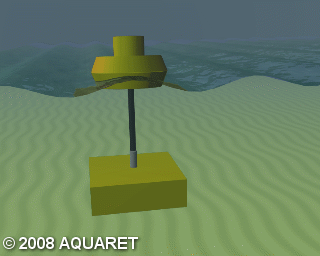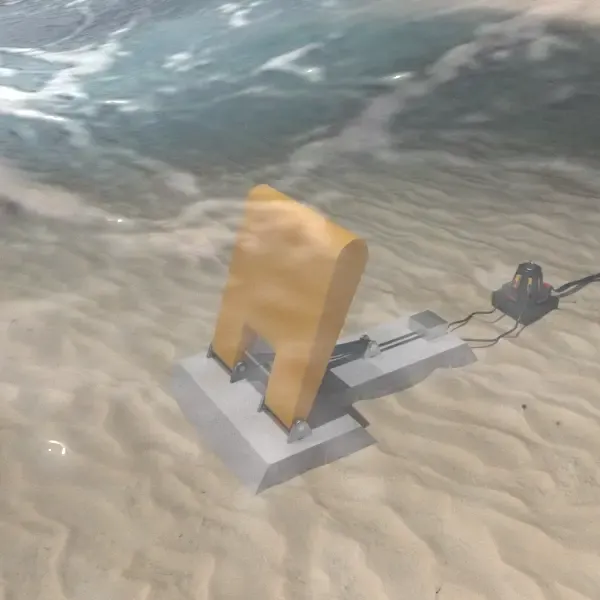

Abaixo, apresentamos uma **visualização do layout de uma fazenda de WECs**, mostrando diferentes formas de posicionamento. Essa visualização ajuda a compreender como **a distribuição espacial afeta a eficiência global**:

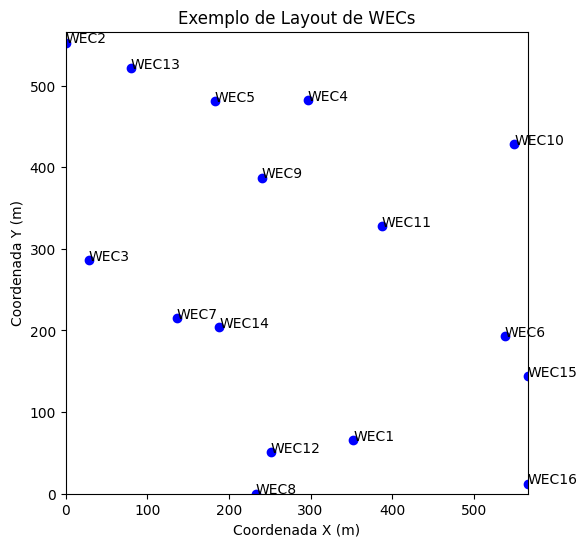

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

random_idx = np.random.randint(0, len(df))

x_values = df[[f"X{i}" for i in range(1, 17)]].iloc[random_idx].values
y_values = df[[f"Y{i}" for i in range(1, 17)]].iloc[random_idx].values

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values, color='blue')

for i in range(16):
    plt.text(x_values[i], y_values[i], f"WEC{i+1}")

plt.xlim(0, 566)
plt.ylim(0, 566)
plt.gca().set_aspect('equal')
plt.title("Exemplo de Layout de WECs")
plt.xlabel("Coordenada X (m)")
plt.ylabel("Coordenada Y (m)")
plt.show()

## Ganhos e insights possíveis com diferentes arranjos:

-   **Disposição regular:** Reduz interferências entre WECs, facilita manutenção e controle.
-   **Disposição escalonada ou hexagonal:** Aumenta a densidade de energia capturada e reduz sombras hidrodinâmicas.
-   **Arranjos adaptativos:** Baseados em modelagem computacional ou simulação de ondas para maximizar a eficiência energética.

# Criação de Novas Features

Nesta etapa, calculamos métricas geométricas a partir das coordenadas dos WECs para capturar a disposição espacial e as interações hidrodinâmicas:

-   **Distâncias Mínimas entre WECs:** Calcula as distâncias entre
-   **Distância ao Centroide:** Calcula a distância de cada WEC ao centroide do arranjo, fornecendo uma medida de dispersão espacial.

------------------------------------------------------------------------

## Distância Euclidiana entre WECs

### O que é?

A **distância euclidiana** é a maneira mais direta de medir a separação entre dois pontos em um plano 2D. No contexto das fazendas de **Wave Energy Converters (WECs)**, ela nos permite quantificar **o espaço físico entre cada par de dispositivos**, que é essencial para analisar interferências hidrodinâmicas e eficiência energética.

------------------------------------------------------------------------

### Fórmula Matemática

Para dois pontos $(i$) e $(j)$ com coordenadas $(X_i, Y_i)$ e $(X_j, Y_j)$, a distância euclidiana é calculada como:

$d_{ij} = \sqrt{(X_i - X_j)^2 + (Y_i - Y_j)^2}, \quad i,j = 1,2,...,N, \quad i < j$

Onde:

-   $(N)$ é o número total de WECs em uma fazenda.

-   $(d_{ij})$ é a **distância direta “linha reta”** entre o WEC $(i)$ e o WEC $(j)$.

------------------------------------------------------------------------

### Como o código escolhe os pontos?

1.  **Seleção dos pontos:** Cada linha do dataframe representa **uma configuração da fazenda de WECs**. Para essa linha, o código cria uma lista de **tuplas** de coordenadas:

$coords = [(X_1, Y_1), (X_2, Y_2), ..., (X_N, Y_N)]$

-   **Gerando pares de WECs:** Usamos `combinations(coords, 2)` do Python, que gera **todos os pares possíveis de WECs sem repetição**.

-   Para 16 WECs, isso resulta em $(\binom{16}{2} = 120)$ pares.

-   Cada par é do tipo $(X_i, Y_i), (X_j, Y_j)$.

-   **Cálculo da distância:** Para cada par, aplica-se a fórmula da distância euclidiana:

$d_{ij} = \sqrt{(X_i - X_j)^2 + (Y_i - Y_j)^2}$

O resultado é uma **lista com todas as distâncias entre pares**, que representa o “mapa de separações” da fazenda.

------------------------------------------------------------------------

### Estatísticas derivadas

A partir das distâncias entre todos os pares, podemos extrair métricas que descrevem o layout da fazenda:

-   **Média:**

$\bar{d} = \frac{1}{M} \sum_{i<j} d_{ij}, \quad M = \binom{N}{2}$

Por que a média é representada assim?

-   $(M = \binom{N}{2} = \frac{N(N-1)}{2})$ é o **número total de pares únicos**.

-   O somatório $(\sum_{i<j} d_{ij})$ adiciona **todas as distâncias entre pares únicos**.

-   Dividindo pelo total de pares $(M)$, obtemos a **distância média entre todos os WECs**, que representa o **espaçamento médio da fazenda**.

-   **Mínimo:**

$d_{min} = \min(d_{ij})$

-   **Máximo:**

$d_{max} = \max(d_{ij})$

-   **Desvio padrão:**

$\sigma_d = \sqrt{\frac{1}{M} \sum_{i<j} (d_{ij} - \bar{d})^2}$

Estas estatísticas permitem avaliar:

-   **Proximidade crítica entre WECs** (evitar interferência hidrodinâmica).
-   **Uniformidade do layout** (distribuição regular ou concentrada).
-   **Potencial de eficiência energética** baseado na posição relativa dos dispositivos.

------------------------------------------------------------------------

### Por que é importante?

1.  **Evitar interferências entre WECs:** Dispositivos muito próximos podem “sombrear” uns aos outros, reduzindo a eficiência da captura de energia.

2.  **Caracterizar o layout da fazenda:** A distância média e o desvio padrão ajudam a identificar padrões espaciais, como agrupamentos ou dispersão uniforme.

3.  **Fornecer features para modelos de predição:** Estatísticas das distâncias podem ser usadas como **entradas em modelos de regressão ou machine learning**, ajudando a prever a potência total gerada (`Powerall`).

------------------------------------------------------------------------

### Visualização Intuitiva

Se representarmos cada WEC como um ponto em um plano 2D, a distância euclidiana é a **linha reta** que conecta dois pontos, sem se importar com o caminho das ondas ou obstáculos. Para todos os pares, podemos pensar em uma **“rede de linhas”** conectando cada dispositivo a todos os outros.

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

n_wecs = 16
x_cols = [f"X{i}" for i in range(1, n_wecs+1)]
y_cols = [f"Y{i}" for i in range(1, n_wecs+1)]

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def pairwise_distances(row):
    coords = [(row[x_cols[i]], row[y_cols[i]]) for i in range(n_wecs)]
    dists = [euclidean_distance(x1, y1, x2, y2)
             for (x1, y1), (x2, y2) in combinations(coords, 2)]
    return dists

df['pairwise_distances'] = df.apply(pairwise_distances, axis=1)

df['dist_mean'] = df['pairwise_distances'].apply(np.mean)
df['dist_min'] = df['pairwise_distances'].apply(np.min)
df['dist_max'] = df['pairwise_distances'].apply(np.max)
df['dist_std'] = df['pairwise_distances'].apply(np.std)

print(df[['dist_mean','dist_min','dist_max','dist_std']].head())

    dist_mean   dist_min    dist_max    dist_std
0  318.669811  53.786210  696.706038  145.638849
1  316.501547  51.749881  614.241595  139.697244
2  346.026541  54.459406  699.690037  162.379271
3  331.598578  50.757900  784.156507  153.154218
4  328.617141  51.050694  671.244559  145.095922


## Distância de cada WEC ao Centroide

### O que é o centroide?

O **centroide** é o **ponto médio** de todos os WECs em uma fazenda, ou seja, o “coração geométrico” da configuração. Se temos $(N)$ WECs com coordenadas $(X_i, Y_i)$, o centroide é calculado como:

$\text{centroid}_x = \frac{1}{N} \sum_{i=1}^{N} X_i, \quad\text{centroid}_y = \frac{1}{N} \sum_{i=1}^{N} Y_i$

-   ((\text{centroid}\_x, \text{centroid}\_y)) representa **a posição média de todos os WECs**.
-   Ele é usado como referência para avaliar **quão dispersos ou concentrados estão os WECs**.

------------------------------------------------------------------------

### Distância de cada WEC até o centroide

Para cada WEC $(i)$, a distância ao centroide é:

$d_i^{\text{centroid}} = \sqrt{(X_i - \text{centroid}_x)^2 + (Y_i - \text{centroid}_y)^2}, \quad i = 1, 2, ..., N$

-   Cada WEC é comparado **apenas com o centroide**.
-   O cálculo é novamente **uma hipotenusa** de um triângulo retângulo formado pela diferença de coordenadas X e Y do WEC até o centroide.

------------------------------------------------------------------------

### Estatísticas derivadas

Com a lista de distâncias $({d_1^{\text{centroid}}, d_2^{\text{centroid}}, ..., d_N^{\text{centroid}}})$ podemos calcular:

-   **Distância média ao centroide:**

$\bar{d}*{\text{centroid}} = \frac{1}{N} \sum_{i=1}^{N} d_i^{\text{centroid}}$

-   **Desvio padrão das distâncias ao centroide:**

$\sigma_{\text{centroid}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (d_i^{\text{centroid}} - \bar{d}_{\text{centroid}})^2}$

Essas métricas permitem:

1.  Avaliar a **dispersão da fazenda**:

    -   $(\bar{d}_{\text{centroid}})$ grande → WECs muito afastados do centro.
    -   $(\sigma_{\text{centroid}})$ grande → WECs distribuídos de forma desigual.

2.  Criar **features para modelagem preditiva**, ajudando a explicar variações na potência gerada.

------------------------------------------------------------------------

### Por que é diferente da distância entre pares?

-   **Distância entre pares:** considera **todos os pares possíveis de WECs**, gerando $\binom{N}{2}$ valores.

-   **Distância até o centroide:** considera **cada WEC apenas em relação ao centro geométrico**, gerando $(N)$ valores.

-   Ambas ajudam a caracterizar a fazenda, mas o centroide **resuma a posição global** enquanto as distâncias entre pares **resumem a interação local**.

------------------------------------------------------------------------

### Visualização Intuitiva

Imagine uma fazenda com 16 WECs espalhados:

-   O **centroide** é o ponto médio (como o *baricentro*) da distribuição.
-   Cada WEC está conectado ao centroide por uma **linha reta**, que é a hipotenusa do triângulo formado pelas diferenças de coordenadas X e Y.

Isso dá uma ideia clara de **quão centralizados ou dispersos os WECs estão**.

------------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

df['centroid_x'] = df[x_cols].mean(axis=1)
df['centroid_y'] = df[y_cols].mean(axis=1)

def dist_to_centroid(row):
    centroid = (row['centroid_x'], row['centroid_y'])
    dists = [euclidean_distance(row[x_cols[i]], row[y_cols[i]], *centroid)
             for i in range(n_wecs)]
    return dists

df['dist_to_centroid'] = df.apply(dist_to_centroid, axis=1)

df['centroid_dist_mean'] = df['dist_to_centroid'].apply(np.mean)
df['centroid_dist_std'] = df['dist_to_centroid'].apply(np.std)

df = df.drop(columns=['pairwise_distances', 'dist_to_centroid'])

print(df[['centroid_dist_mean','centroid_dist_std']].head())

   centroid_dist_mean  centroid_dist_std
0          216.708050         102.868349
1          229.015546          60.463932
2          242.446731          98.511988
3          227.486944         103.862523
4          232.300129          80.778165


## "Matriz de Correlação"

A matriz de correlação é uma ferramenta estatística que mostra a relação linear entre cada par de variáveis em um dataset. No contexto do nosso projeto, ela nos ajuda a entender como as novas features geométricas (como `dist_mean`, `dist_min`, `centroid_dist_mean`, etc.) estão relacionadas com a variável alvo `Powerall`. Foi utilizado " " porque não é uma matriz de correlação tradicional entre todas as variáveis, mas sim um gráfico de calor focado na correlação de cada feature com `Powerall`, já que a base de dados possui muitas colunas, e o objetivo é destacar a correlação de cada feature com a variável alvo.

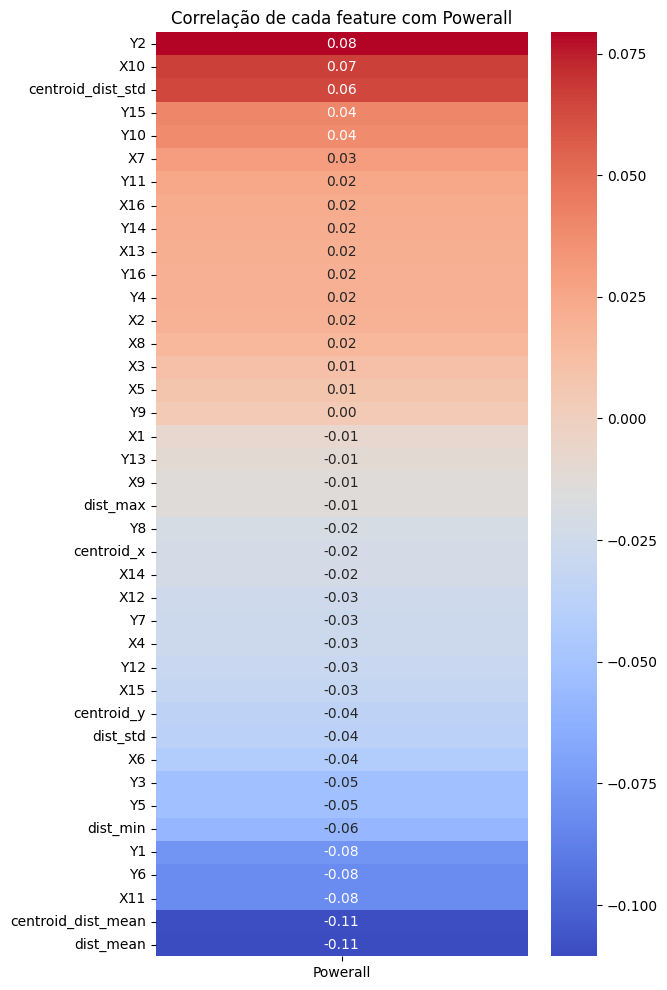

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleciona apenas as colunas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Calcula a correlação com PowerAll
corr_with_target = df_numeric.corr()['Powerall'].drop('Powerall')  # remove a correlação consigo mesmo

# Converte para DataFrame para usar no heatmap
corr_df = corr_with_target.to_frame().sort_values(by='Powerall', ascending=False)

plt.figure(figsize=(6, len(corr_df)*0.3))  # ajusta altura dinamicamente
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlação de cada feature com Powerall")
plt.show()

### Interpretação Geral

A baixa magnitude das correlações reforça que **a relação entre layout dos WECs e potência total é complexa e não-linear**, justificando a necessidade de:

-   Features derivadas (distâncias entre pares, distâncias ao centroide, métricas estatísticas).
-   Modelos mais sofisticados que capturem interações e efeitos não-lineares, como **regressão polinomial ou modelos baseados em árvores**.

Em resumo, **nenhuma feature isolada tem poder explicativo forte**, mas a combinação de várias métricas espaciais pode fornecer insights importantes para previsão de `Powerall`.

# Exportação da Base de Dados Tratada

-   Novas Features Criadas para melhor desempenho do Modelo
-   Salvamento em formato `.parquet` para otimização de leitura e escrita.

In [ ]:
output_path = PROCESSED_DIR / "wec_all_processed.parquet"
df.to_parquet(output_path, engine="fastparquet")
print(f"\nDataset Tratado salvo em: {output_path}")


Dataset Tratado salvo em: /content/drive/MyDrive/DL/P1_RL/data/processed/wec_all_processed.parquet
